# CounterFactual Experiment

This notebook demonstrates the generation and visualization of counterfactual explanations using DPG constraints.

## Import Libraries

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from CounterFactualModel import CounterFactualModel
from ConstraintParser import ConstraintParser
from CounterFactualVisualizer import plot_pca_with_counterfactual, plot_sample_and_counterfactual_heatmap
from CounterFactualExplainer import CounterFactualExplainer

import itertools

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

## Training Machine Learning Model

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier with 3 base learners
model = RandomForestClassifier(n_estimators=3, random_state=42)
model.fit(X_train, y_train)

,n_estimators,3
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Opening Constraints Extracted from DPG

In [3]:
parser = ConstraintParser("constraints/custom_l100_pv0.001_t2_dpg_metrics.txt")
constraints = parser.read_constraints_from_file()
print(constraints)

{'Class 0': [{'feature': 'petal_length', 'min': None, 'max': 5.05}, {'feature': 'petal_width', 'min': None, 'max': 1.75}, {'feature': 'sepal_length', 'min': 5.15, 'max': 6.15}, {'feature': 'sepal_width', 'min': 2.8, 'max': 3.25}], 'Class 1': [{'feature': 'petal_length', 'min': 2.15, 'max': 5.45}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 7.1}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.7}], 'Class 2': [{'feature': 'petal_length', 'min': 2.35, 'max': 5.25}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 6.75}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.25}]}


In [4]:
# Example usage
validity = ConstraintParser.is_value_valid_for_class("Class 1", "petal width (cm)", 0.5, constraints)
print(validity)

True


## Prepare Sample Data

In [5]:
# Original sample
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}

# Create a DataFrame from the sample
sample_df = pd.DataFrame([sample])  # Wrapping sample in a list to create a DataFrame

## Generating Counterfactual Samples

In [6]:
# Initialize the CounterFactualDPG class with the model and constraints
cf_dpg = CounterFactualModel(model, constraints, verbose=True)  # Ensure you are using the correct constraints (nested_dict)
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'no_change'}
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
#dict_non_actionable = {'petal width (cm)': 'no_change', 'sepal length (cm)': 'non_decreasing'}
dict_non_actionable = {}

target_class = 0
cf_dpg.dict_non_actionable = dict_non_actionable
counterfactual = cf_dpg.generate_counterfactual(sample, target_class, 20, 1000)

****** Generation 1: Average Fitness = 26.4598, Best Fitness = 26.4598, fitness improvement = inf
****** Generation 2: Average Fitness = 26.5957, Best Fitness = 26.5957, fitness improvement = -0.1358
****** Generation 3: Average Fitness = 26.3494, Best Fitness = 26.0104, fitness improvement = 0.5852
****** Generation 4: Average Fitness = 26.2817, Best Fitness = 25.0065, fitness improvement = 1.0039
****** Generation 5: Average Fitness = 26.0028, Best Fitness = 24.4525, fitness improvement = 0.5540
****** Generation 6: Average Fitness = 25.3930, Best Fitness = 23.9186, fitness improvement = 0.5339
****** Generation 7: Average Fitness = 24.4051, Best Fitness = 23.2544, fitness improvement = 0.6642
****** Generation 8: Average Fitness = 24.0061, Best Fitness = 23.2039, fitness improvement = 0.0505
****** Generation 9: Average Fitness = 23.9239, Best Fitness = 23.0176, fitness improvement = 0.1863
****** Generation 10: Average Fitness = 23.5863, Best Fitness = 22.6542, fitness improvement 

In [7]:
print("Original:", sample)
print("Generated Counterfactual:", counterfactual)

predicted_class = model.predict(sample_df)
print("Predicted Class for Original Sample:", predicted_class)
print('Prediction Class CounterFactual', model.predict(pd.DataFrame([counterfactual])))

Original: {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
Generated Counterfactual: {'petal width (cm)': np.float64(6.1), 'petal length (cm)': np.float64(2.8), 'sepal length (cm)': np.float64(4.96), 'sepal width (cm)': np.float64(0.79)}
Predicted Class for Original Sample: [1]
Prediction Class CounterFactual [0]


## Visualizing Counterfactual Samples

<module 'matplotlib.pyplot' from '/home/rafael/gitgud/CounterFactualDPG/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

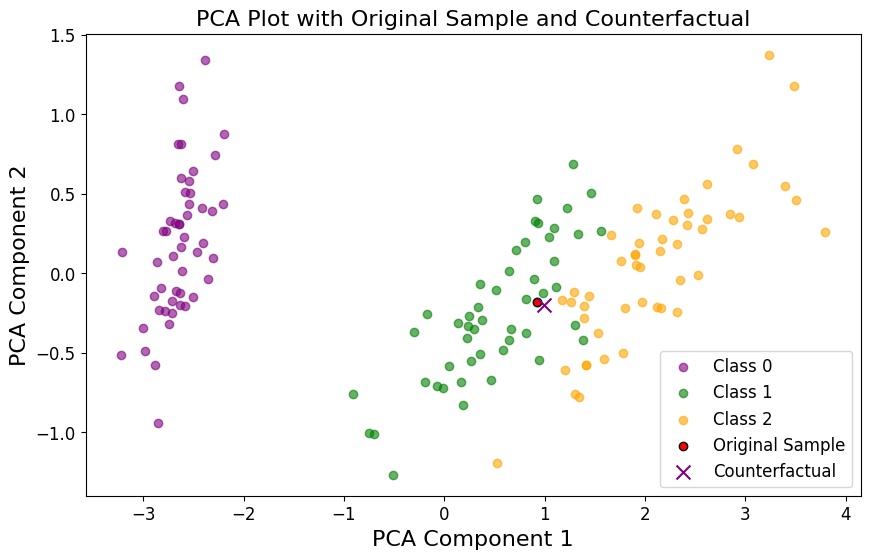

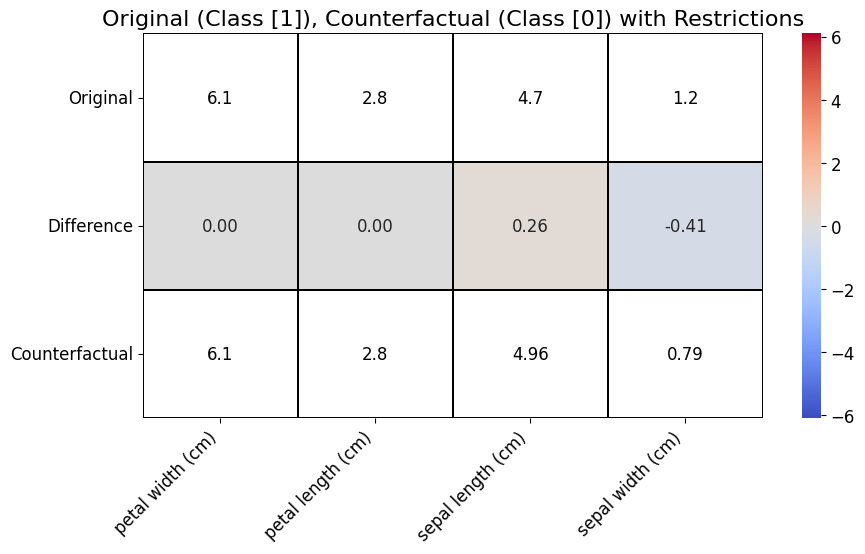

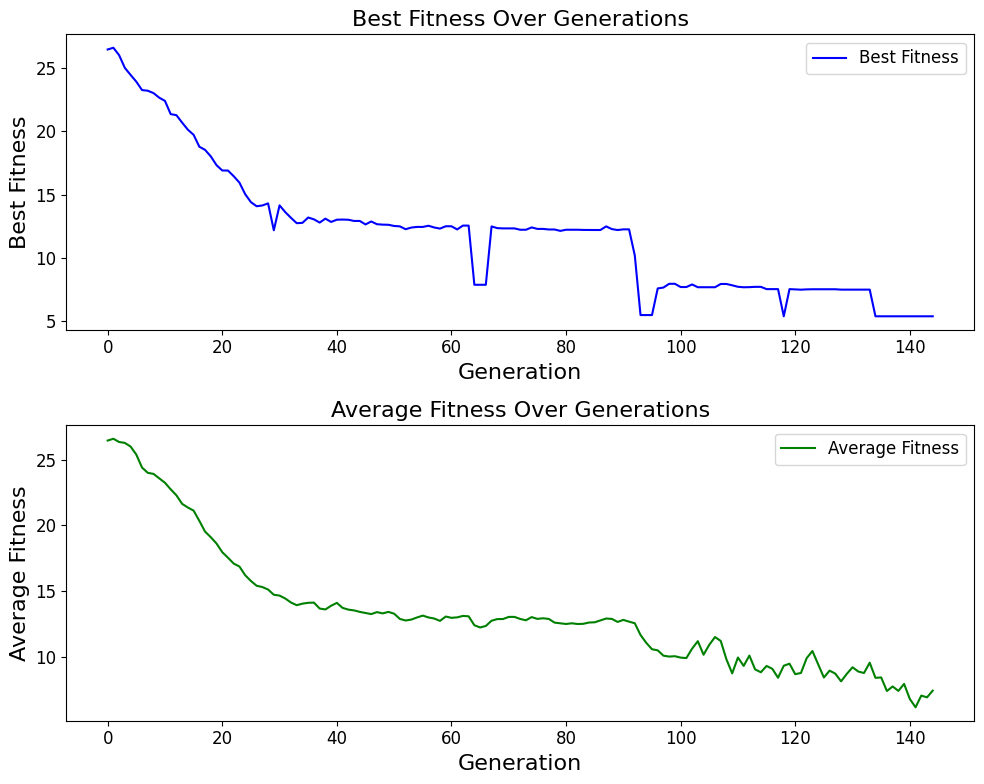

In [8]:
plot_pca_with_counterfactual(model, X, y, sample, counterfactual)
plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)
cf_dpg.plot_fitness()

## Explaining Counterfactual Samples

## Generate Counterfactuals with All Rule Combinations

    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               4.12               0.32               3.43              2.64   
1               2.27               1.71               5.95              0.83   
2               4.86               1.16               7.84              3.01   
3               4.78               6.15               2.91              3.63   
4               3.09               6.82               7.83              0.88   
5               4.11               6.10               6.42              4.82   
6               7.40               1.37               2.96              3.38   
7               8.10               0.00               6.20              0.81   
8               7.77               1.85               6.81              3.35   
9               8.12               5.75               3.27              4.44   
10              8.53               6.88               6.48              0.85   
11              8.47               5.25 

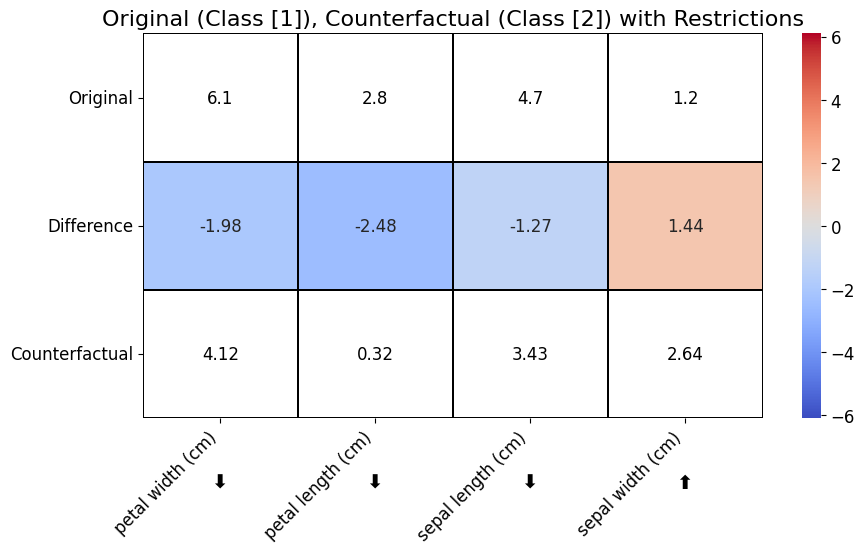

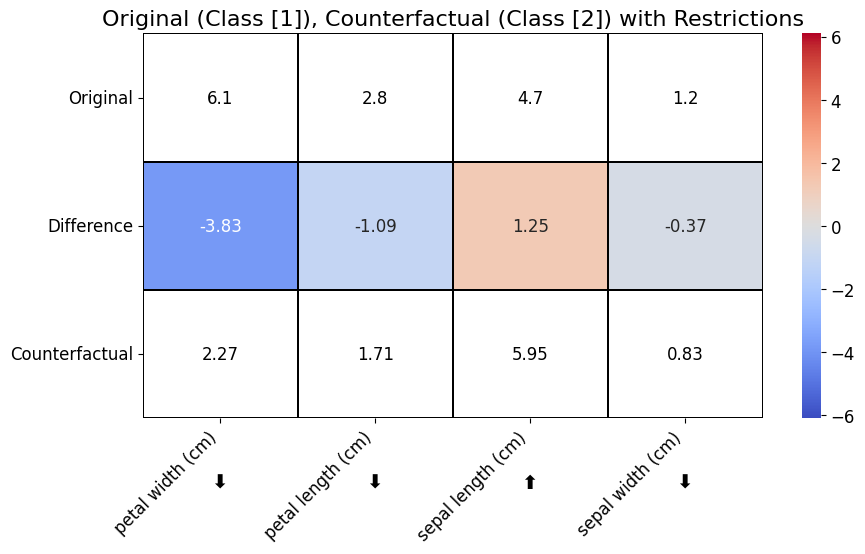

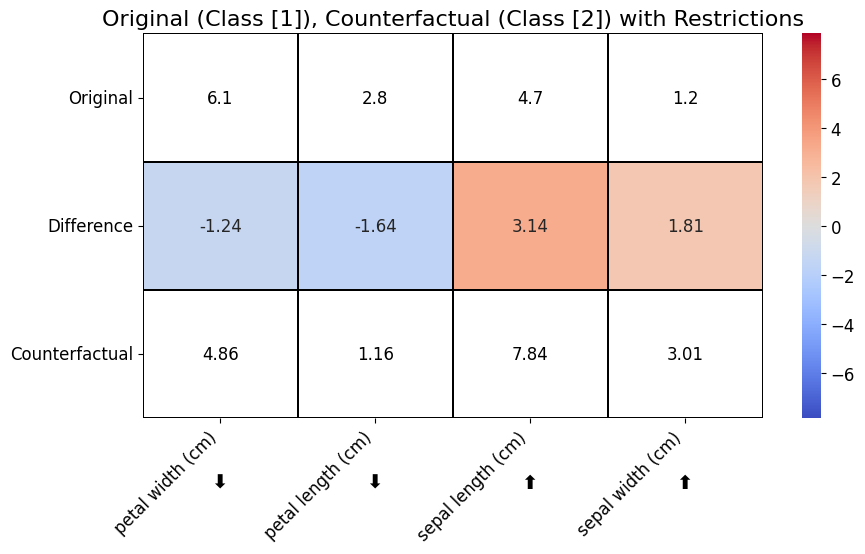

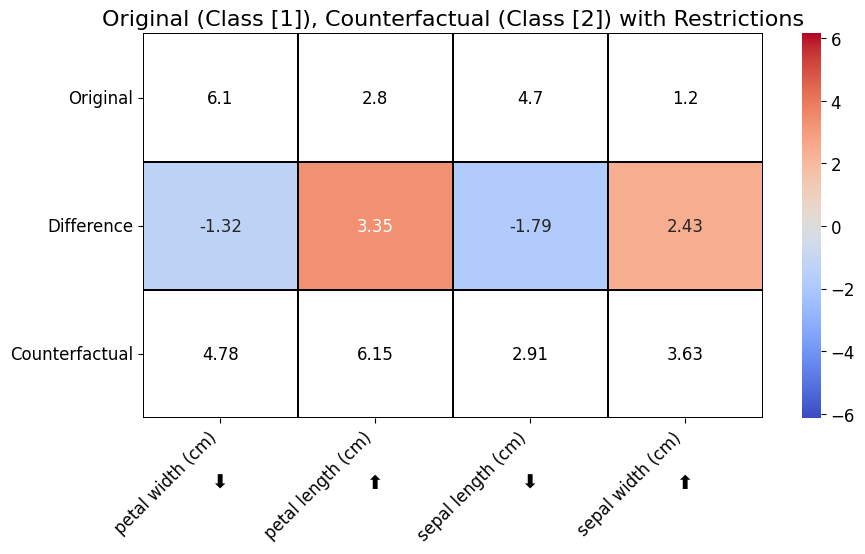

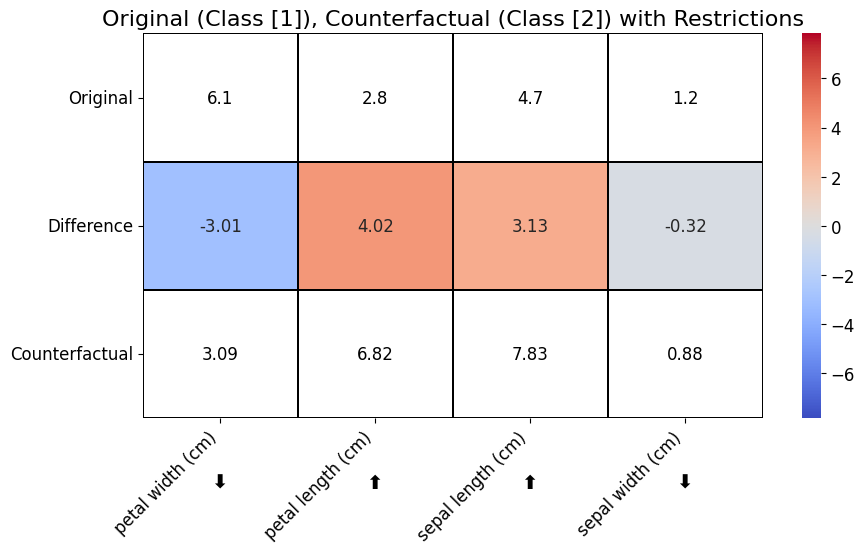

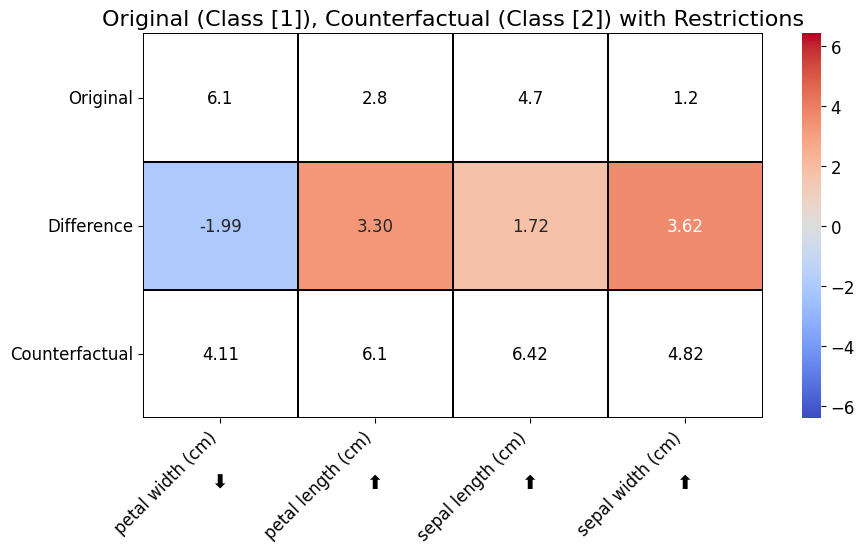

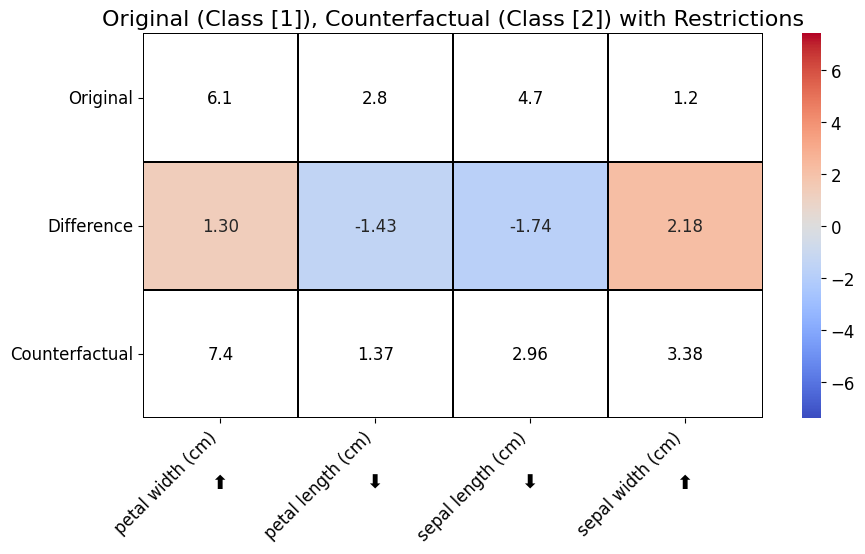

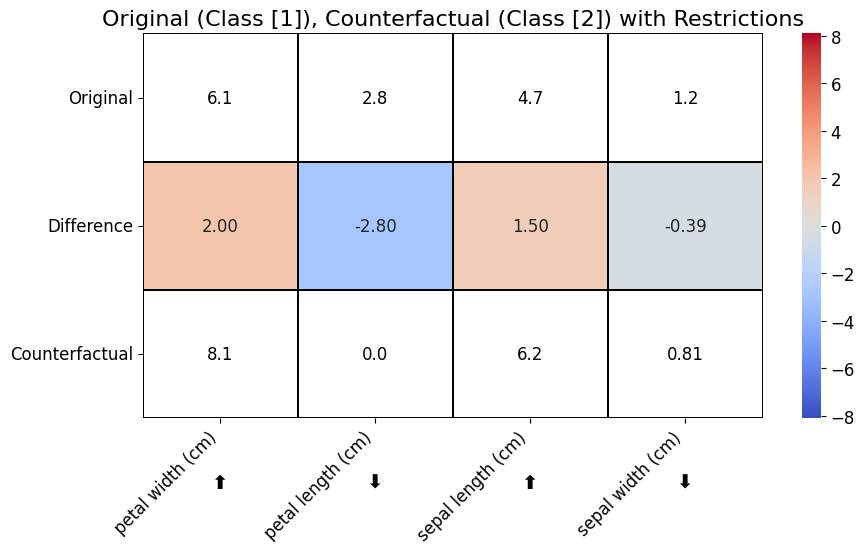

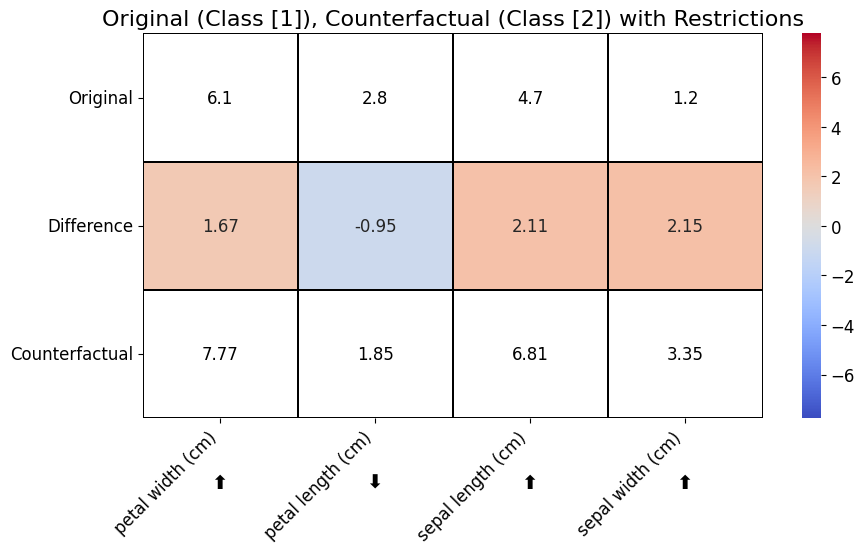

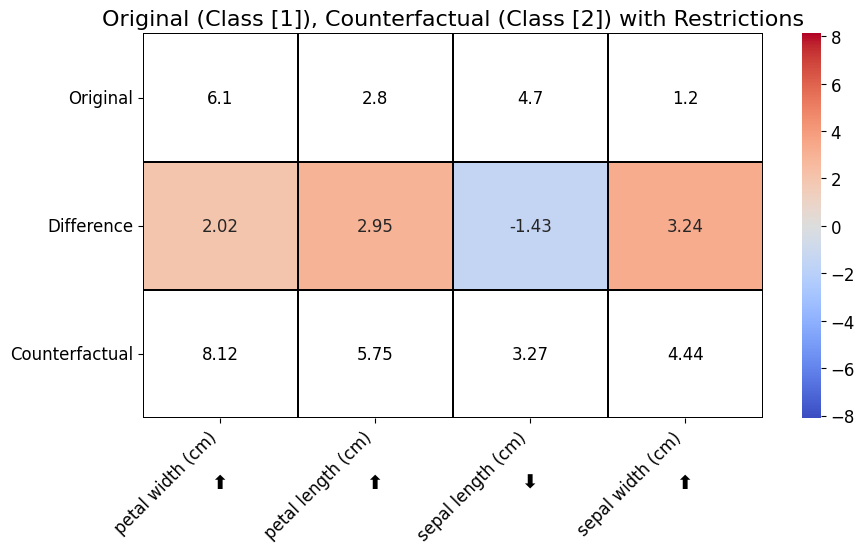

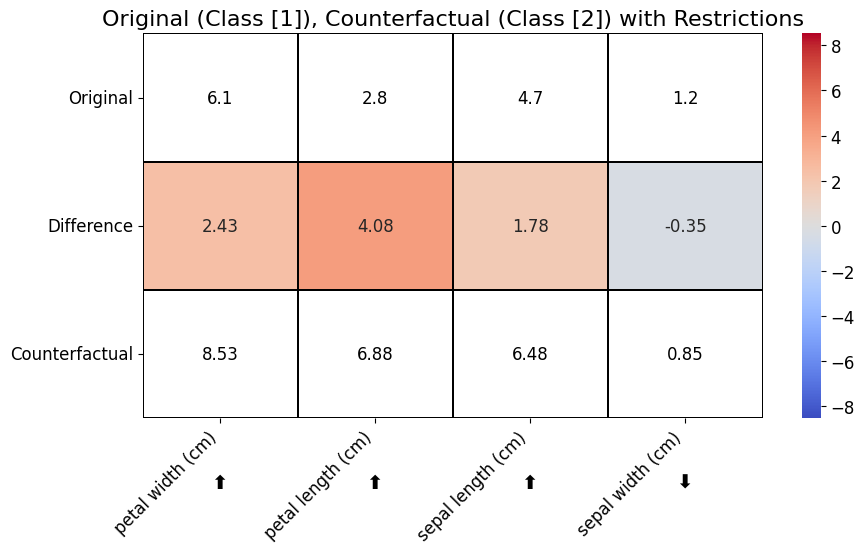

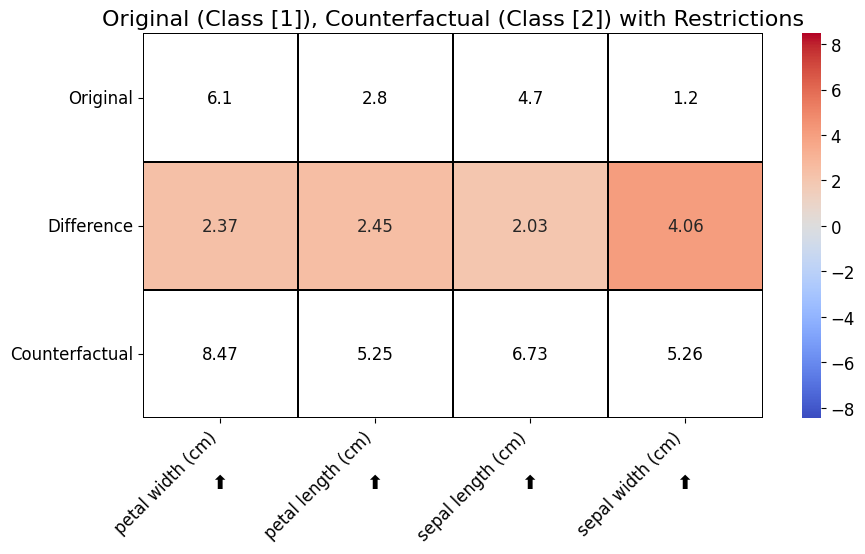

In [9]:
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
rules = ['non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df_combinations = []

# Iterate through each combination of rules
for combination in rule_combinations:
    dict_non_actionable = dict(zip(feature_names, combination))

    # Create an instance of the CounterFactualModel class
    cf_dpg = CounterFactualModel(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df_combinations.append(cf_data)

counterfactuals_df_combinations = pd.DataFrame(counterfactuals_df_combinations)
# Displaying the DataFrame
print(counterfactuals_df_combinations)

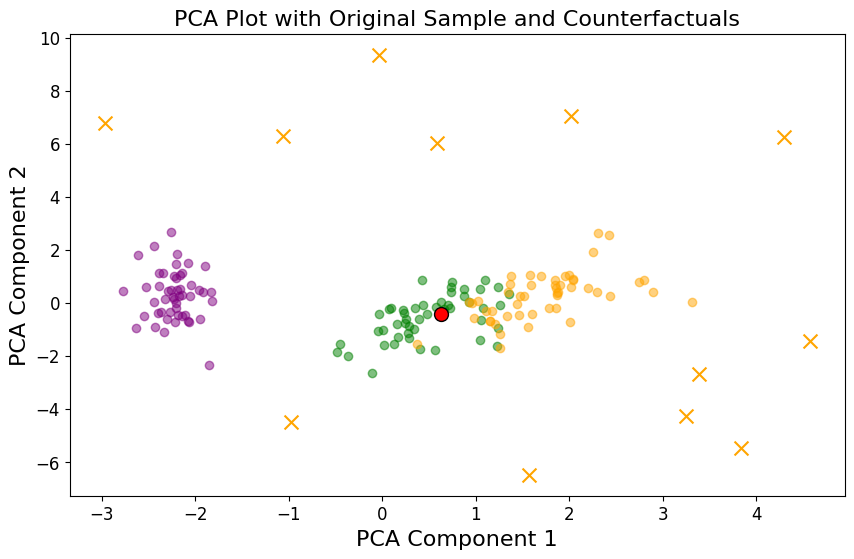

In [10]:
from CounterFactualVisualizer import plot_pca_with_counterfactuals

plot_pca_with_counterfactuals(model, pd.DataFrame(X), y, sample, counterfactuals_df_combinations)

## Generate Multiple Counterfactuals with Replications

In [11]:
explainer = CounterFactualExplainer(cf_dpg, sample, counterfactual, target_class)
print(explainer.explain_feature_modifications())
print(explainer.check_constraints_respect())
print(explainer.explain_stopping_criteria())
print(explainer.summarize_final_results())

Feature 'petal width (cm)' changed from 6.1 to 8.47.
Feature 'petal length (cm)' changed from 2.8 to 5.25.
Feature 'sepal length (cm)' changed from 4.7 to 6.73.
Feature 'sepal width (cm)' changed from 1.2 to 5.26.
All constraints were respected.
Stopping criteria not set or not reached.
Original class: 1, Counterfactual class: 2
Original fitness: inf, Best fitness: inf


    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               6.10               2.80               4.97              0.55   
1               6.10               3.16               5.35              0.81   
2               6.58               3.58               5.01              0.81   
3               5.74               2.94               5.46              0.76   
4               6.10               2.50               4.96              0.82   
5               6.10               2.80               5.58              0.81   
6               6.10               3.01               5.40              0.82   
7               6.10               2.62               5.37              0.44   
8               5.74               3.71               5.99              0.83   
9               6.10               3.28               5.00              0.81   
10              6.10               2.69               4.99              0.60   
11              6.10               2.80 

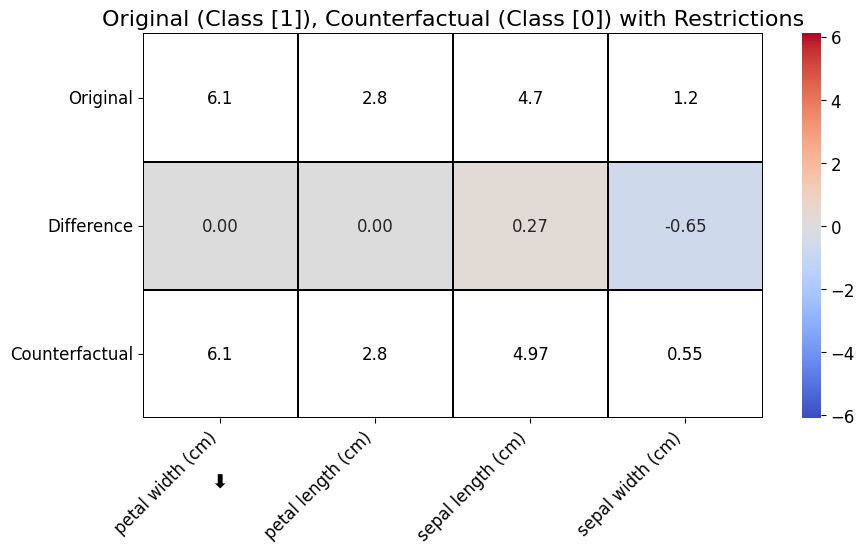

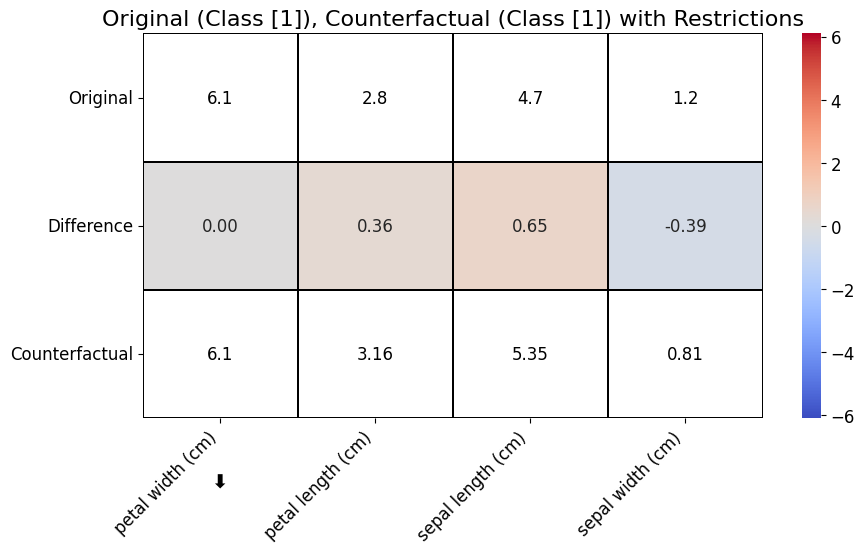

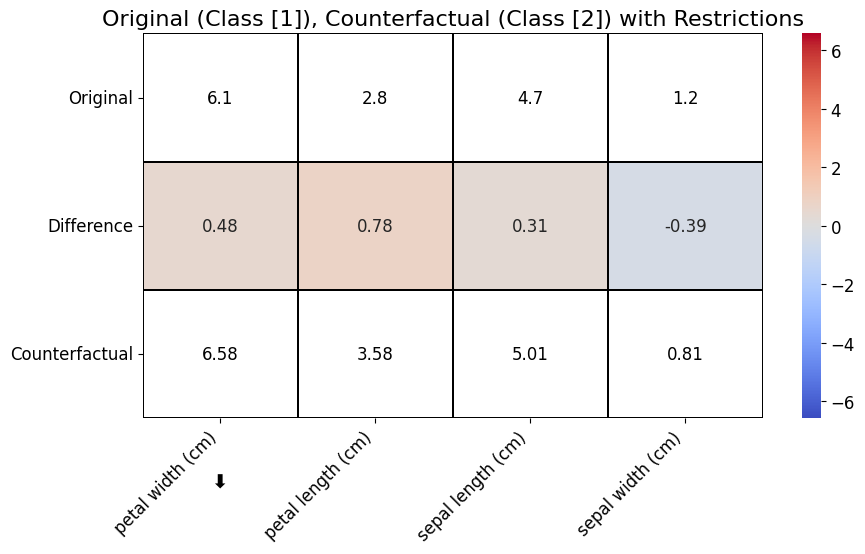

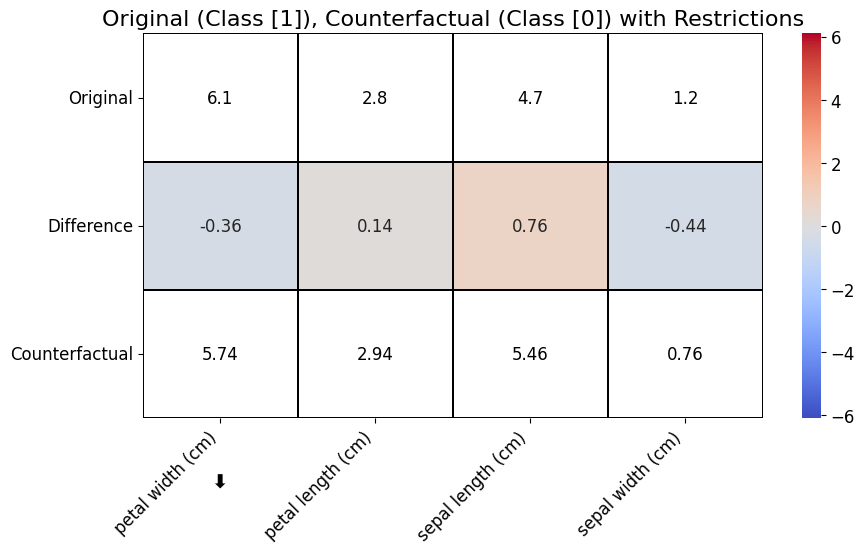

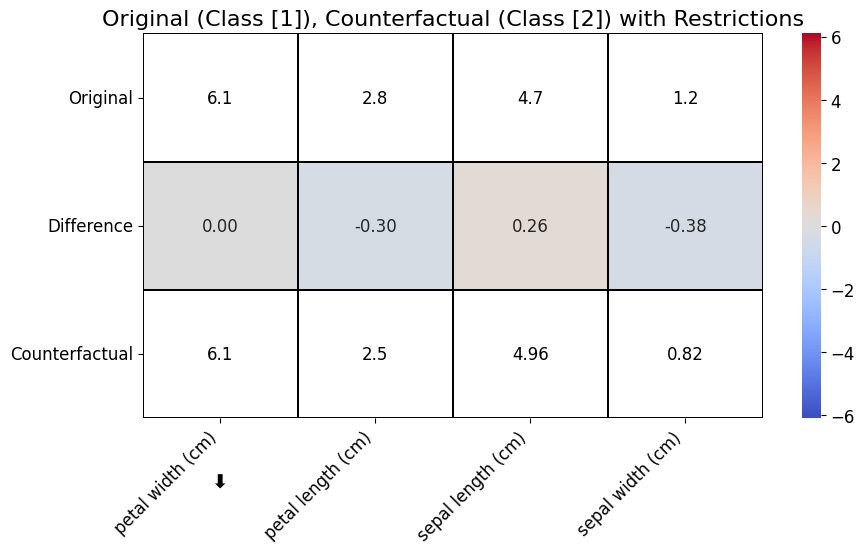

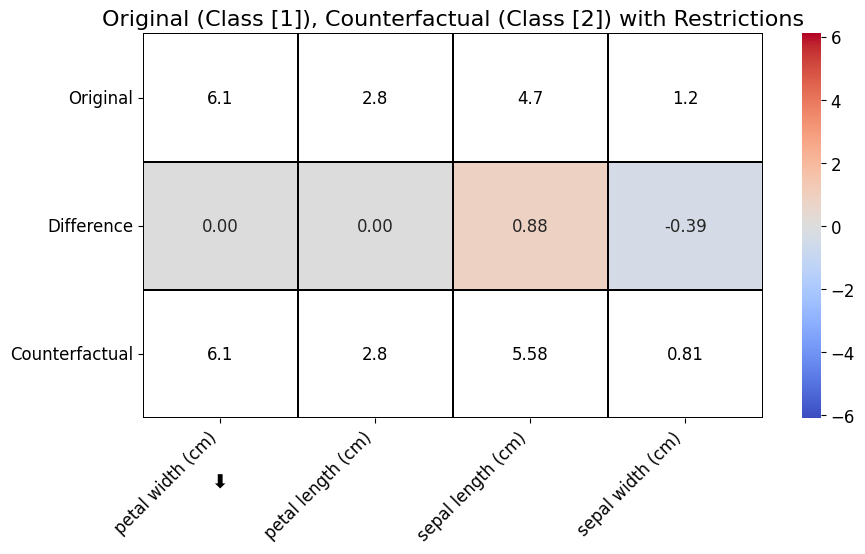

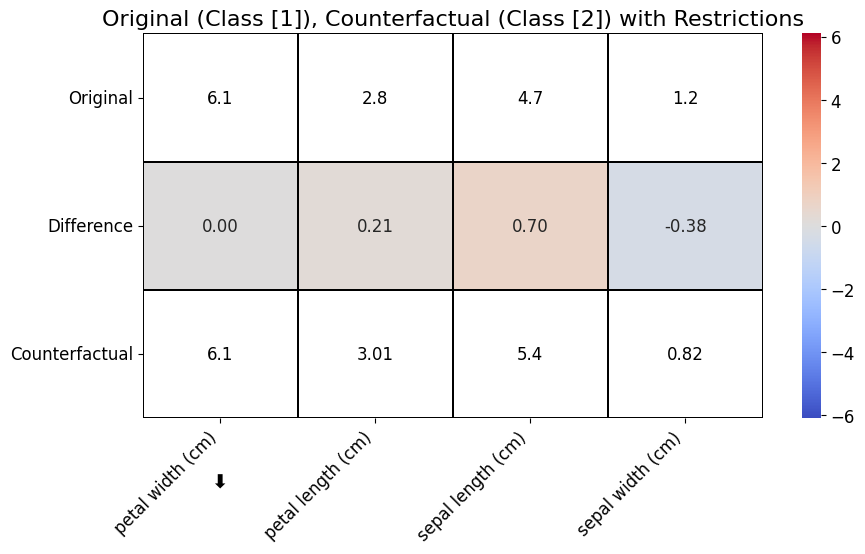

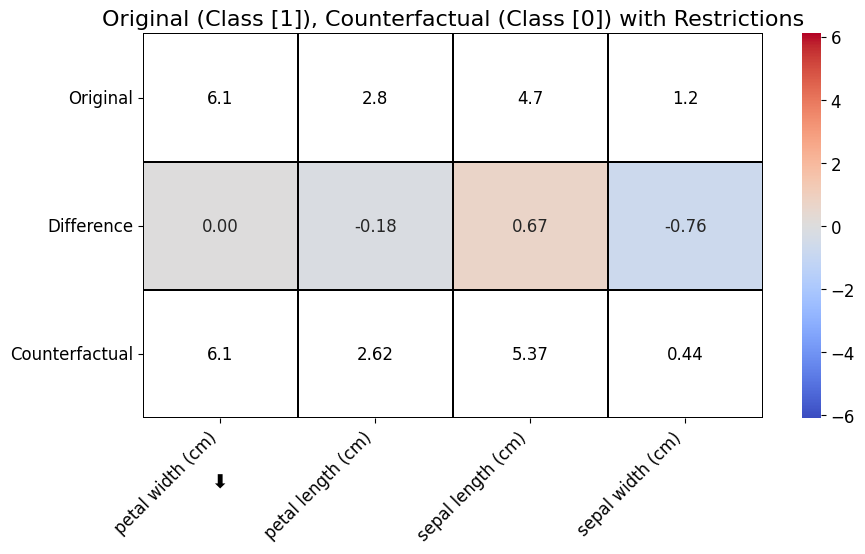

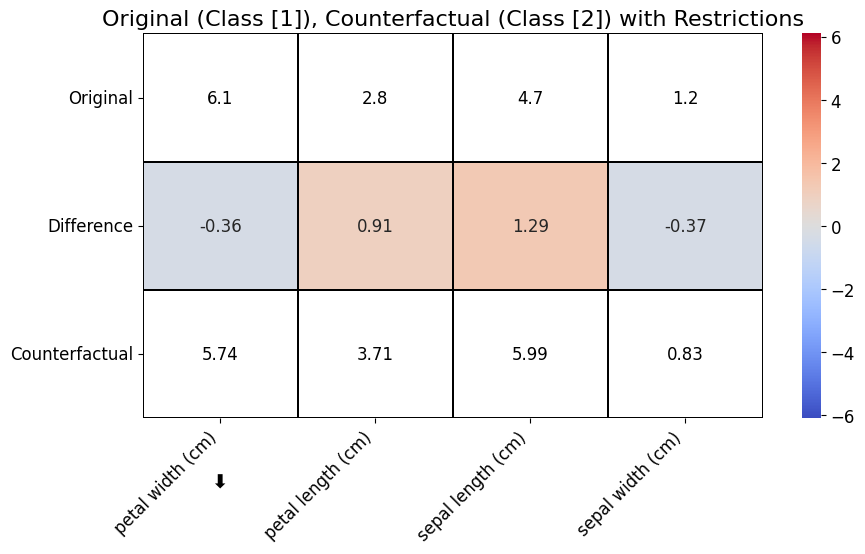

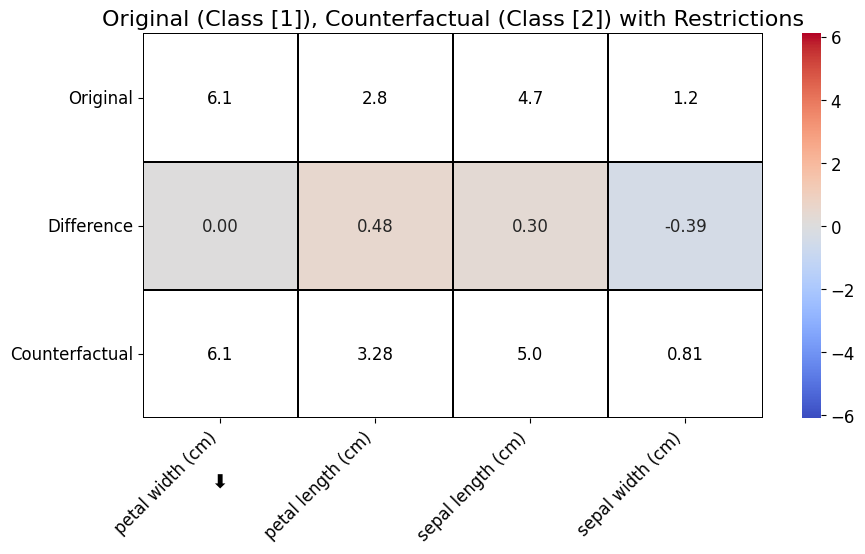

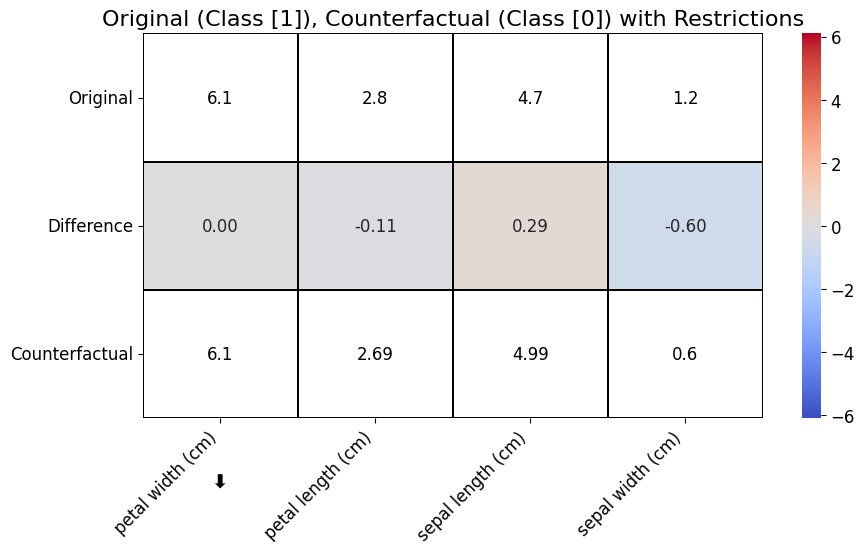

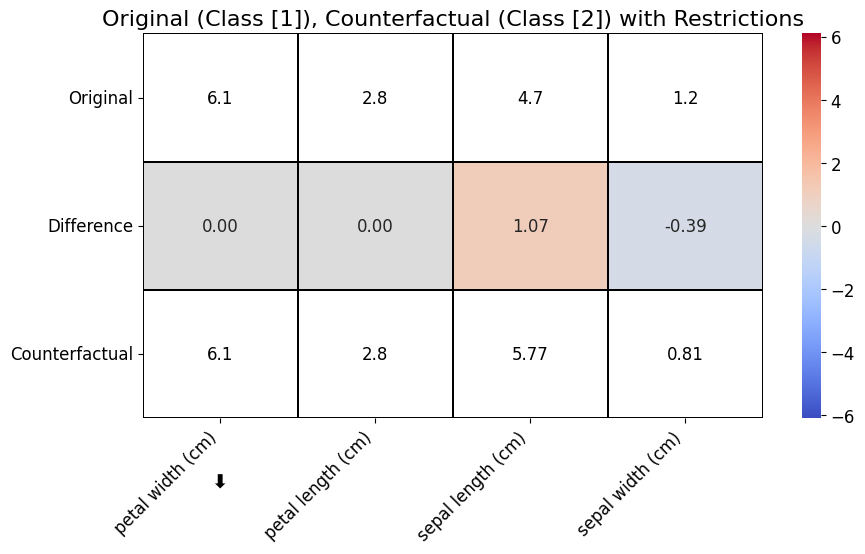

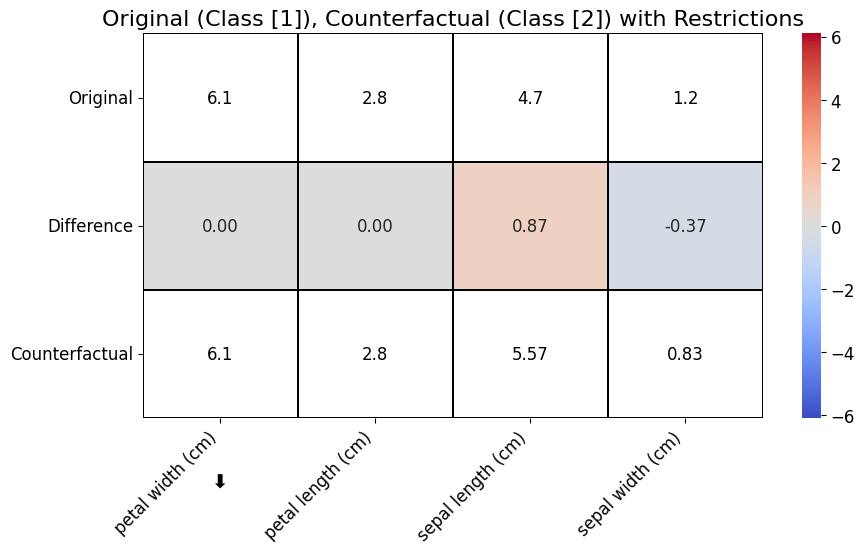

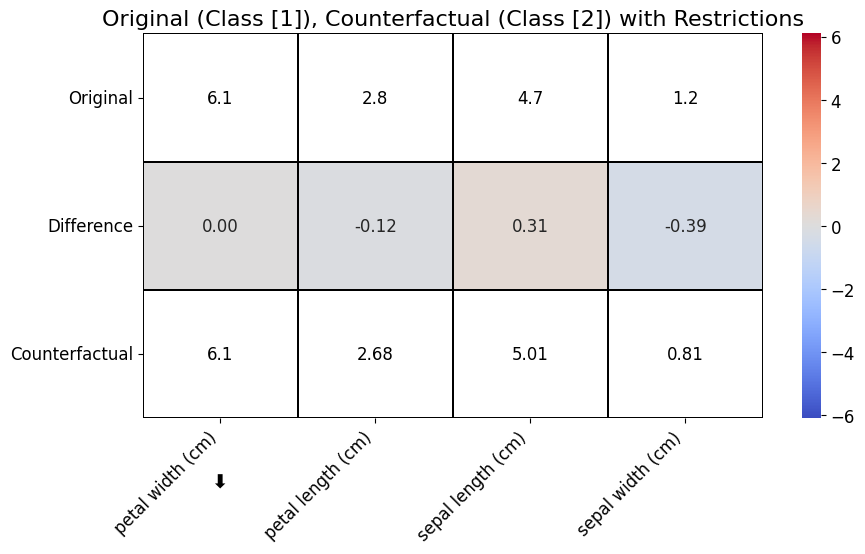

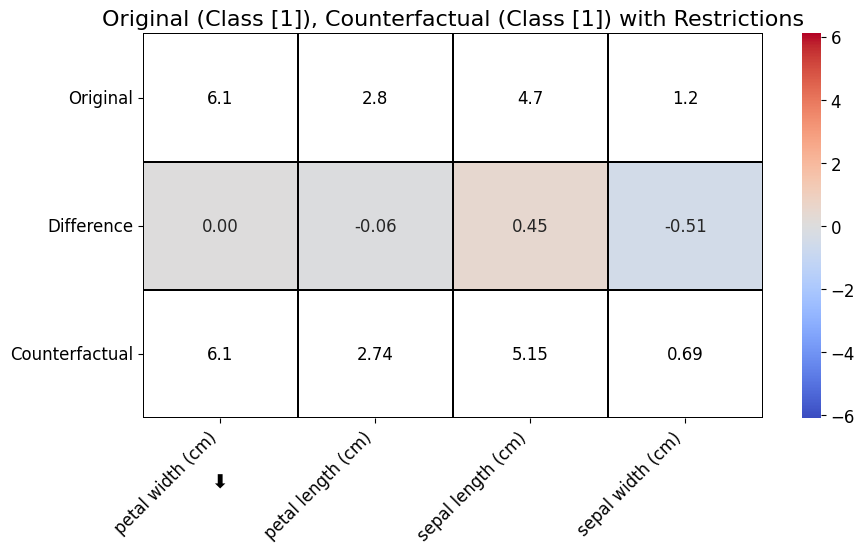

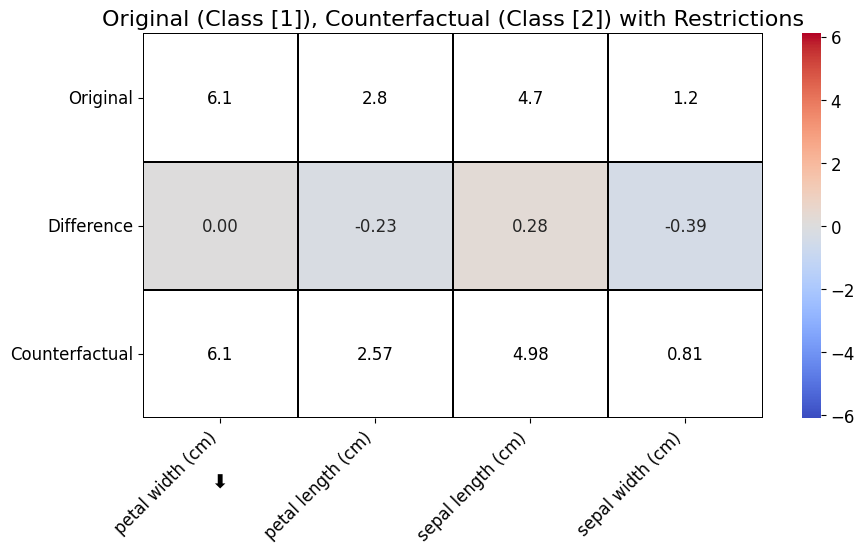

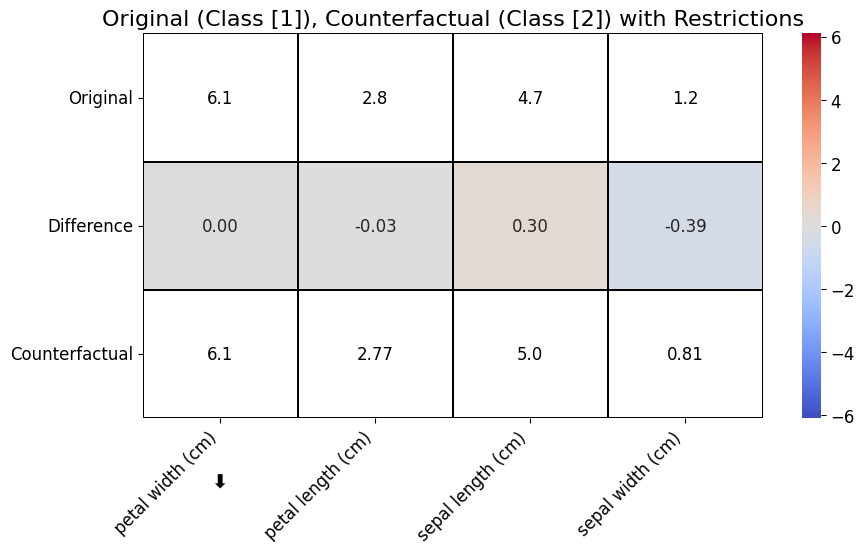

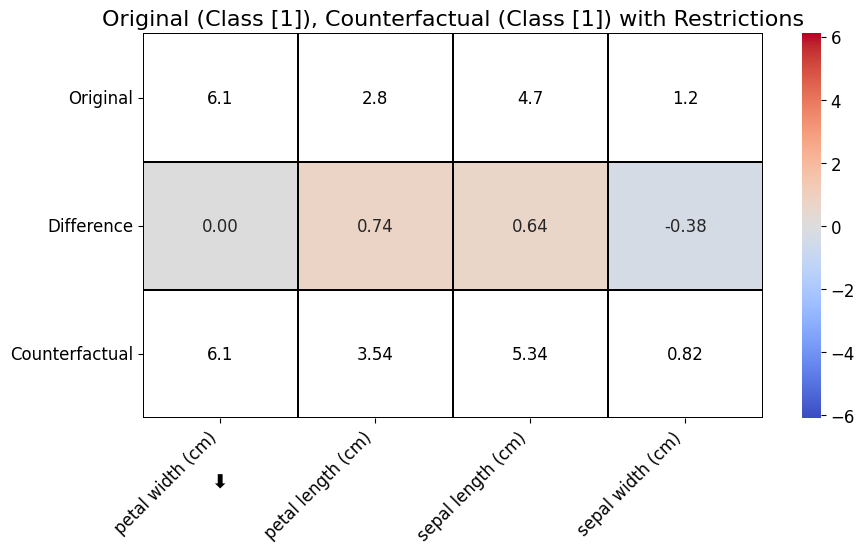

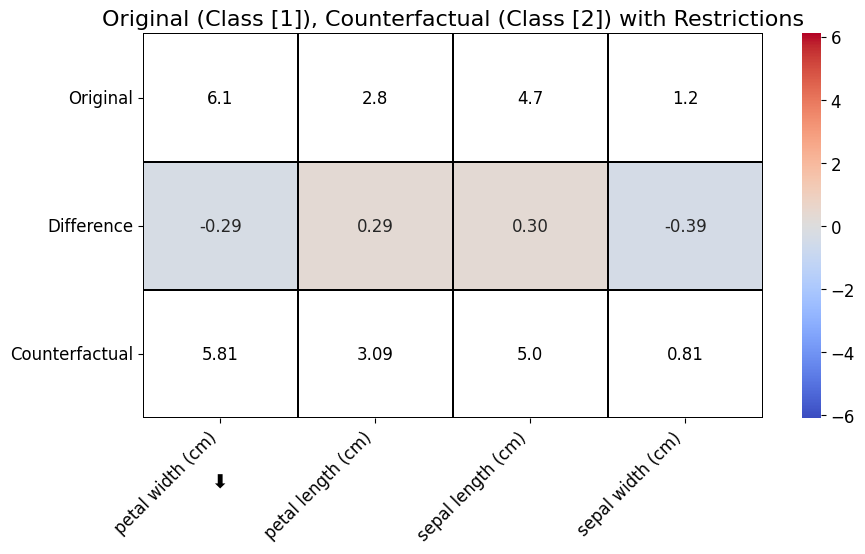

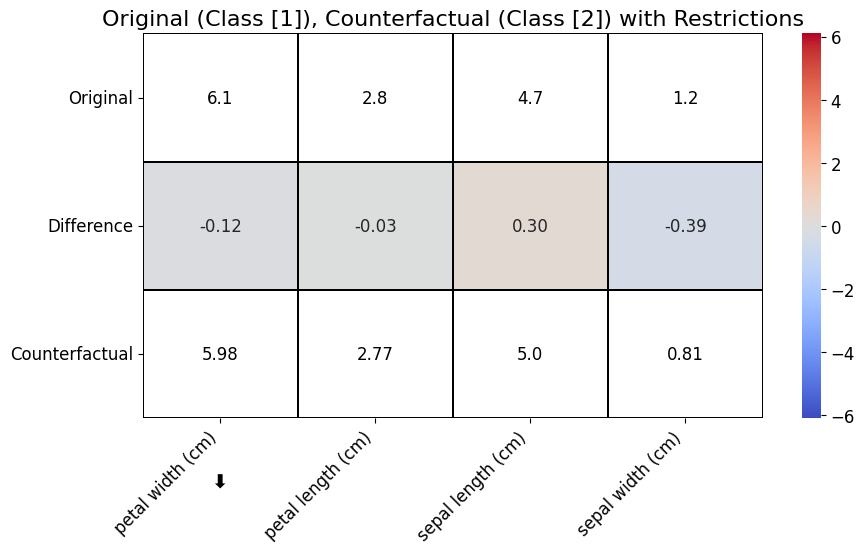

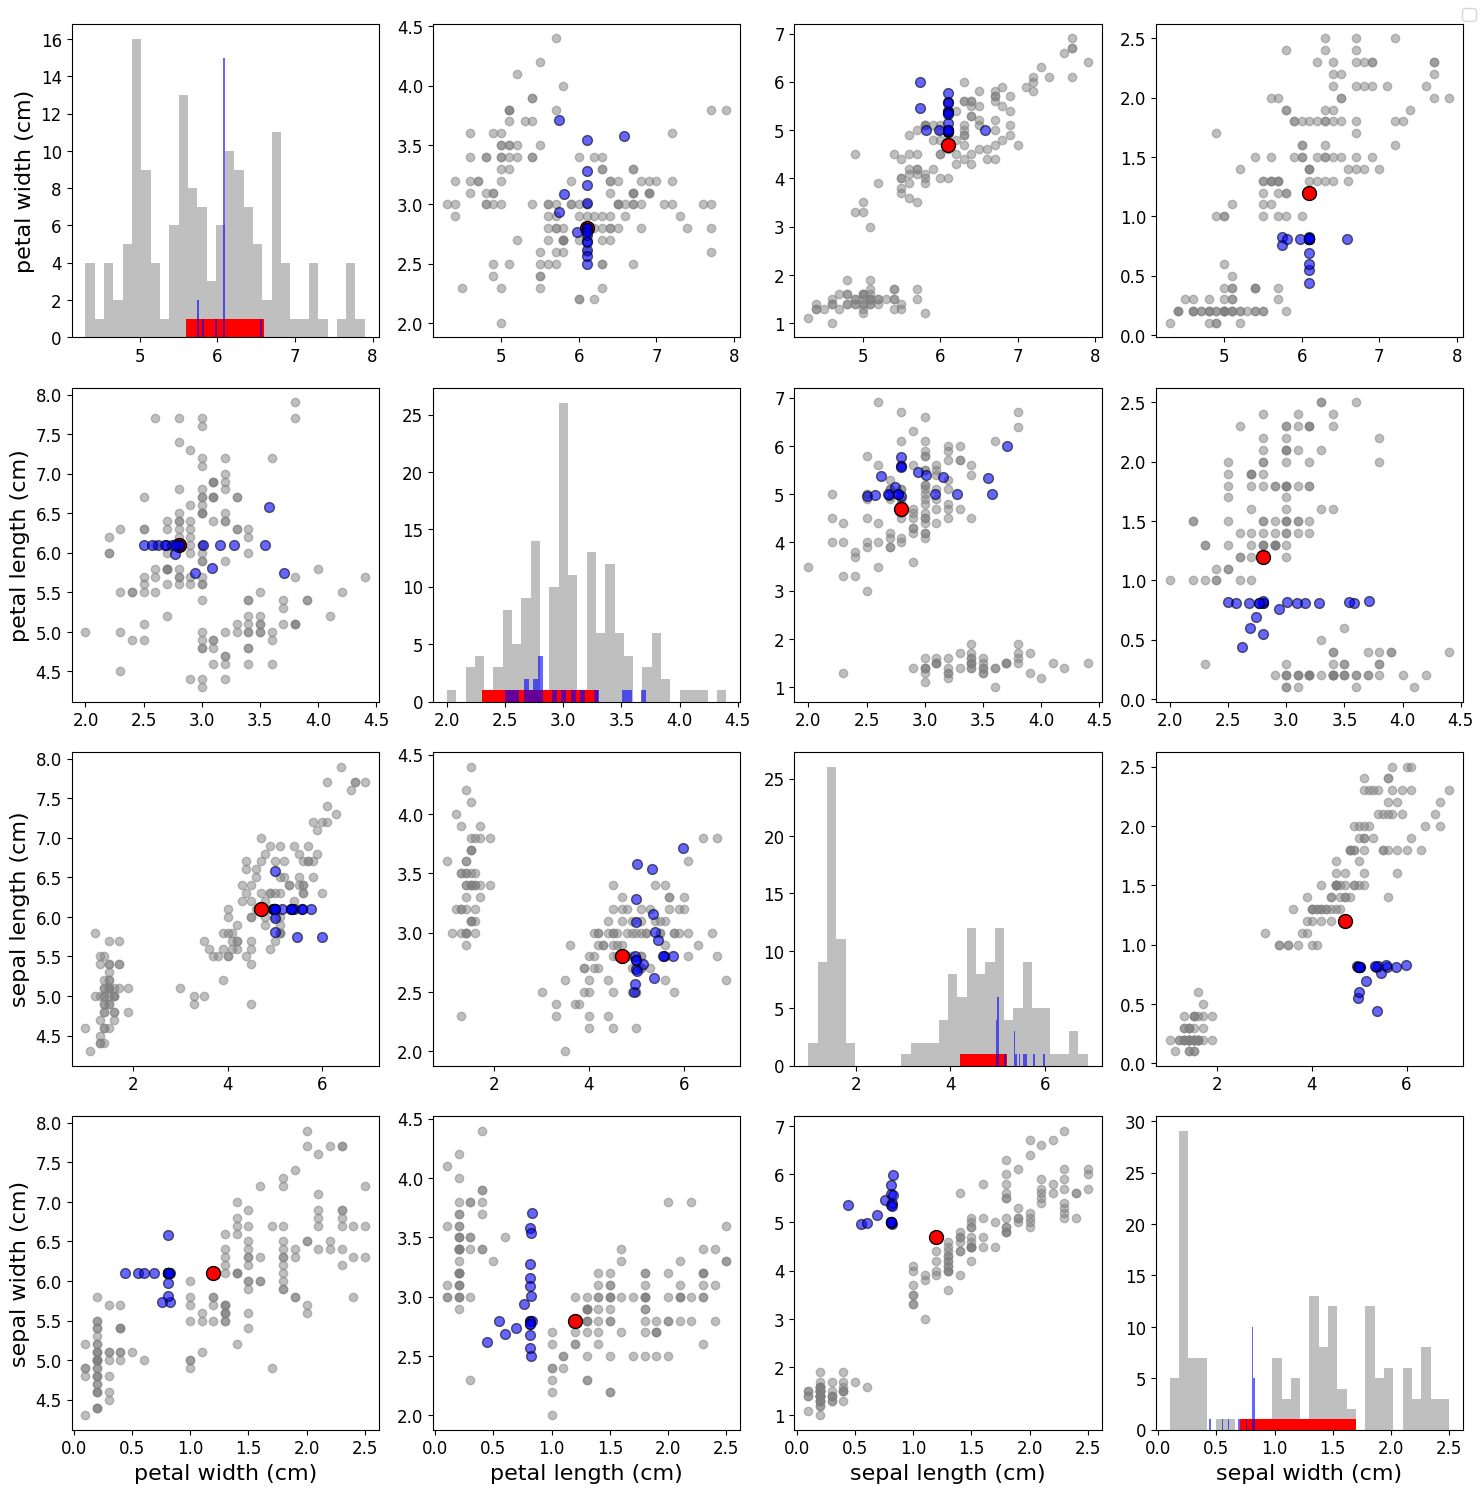

In [12]:
from CounterFactualVisualizer import plot_pairwise_with_counterfactual_df


sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
rules = ['no_change', 'non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df = []

for replicatons in range(20):
  # Iterate through each combination of rules
    #dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
    dict_non_actionable = {'sepal width (cm)': 'non_increasing'}

    # Create an instance of the CounterFactualModel class
    cf_dpg = CounterFactualModel(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df.append(cf_data)

counterfactuals_df = pd.DataFrame(counterfactuals_df)
# Displaying the DataFrame
print(counterfactuals_df)

plot_pairwise_with_counterfactual_df(model, X, y, sample, counterfactuals_df)